In [1]:
!nvidia-smi

Fri May 10 00:39:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    On   | 00000000:86:00.0 Off |                  N/A |
| 41%   32C    P8    18W / 280W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

import torch


sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

In [3]:
from hi_sam.text_segmentation import load_sam_predictor, make_text_segmentation_args


arg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_textseg.pth',
    input_size=(512, 512),
    hier_det=False,
)

sam = load_sam_predictor(arg)


Freeze image encoder.
<All keys matched successfully>


In [4]:
import numpy as np
from PIL import Image


def binary_mask_to_pil(mask: np.array):
    if len(mask.shape) == 3:
        assert mask.shape[0] == 1
        mask = mask[0].astype(np.uint8) * 255
    elif len(mask.shape) == 2:
        mask = mask.astype(np.uint8) * 255
    else:
        raise NotImplementedError
    mask = Image.fromarray(mask)
    return mask

In [5]:
from IPython.display import display

from diffusers.utils import load_image
from hi_sam.text_segmentation import run_text_stroke_segmentation


hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '1.jpg')

mask_w_patchify = run_text_stroke_segmentation(sam_detector=sam, image=input_image, patch_mode=True)

  0%|          | 0/4 [00:00<?, ?it/s]/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

Mask shape:  (512, 512)


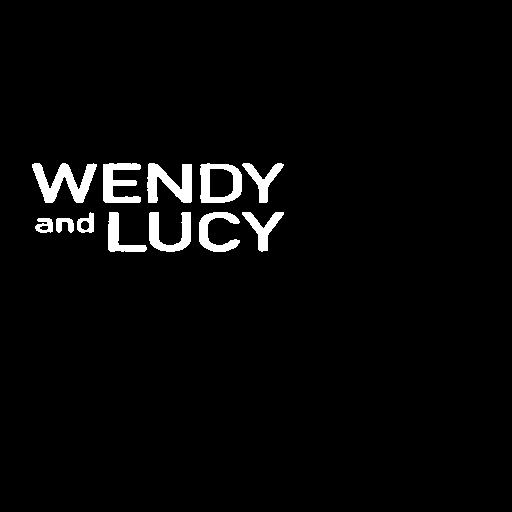

In [6]:
display(binary_mask_to_pil(mask_w_patchify))

In [7]:
mask_wo_patchify = run_text_stroke_segmentation(sam_detector=sam, image=input_image, patch_mode=False)

Mask shape:  (1, 512, 512)


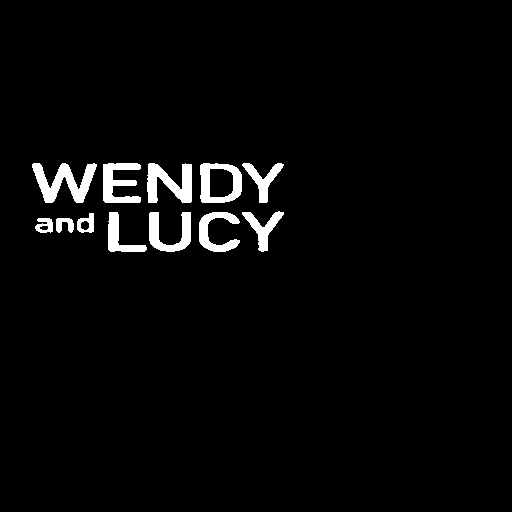

In [8]:
display(binary_mask_to_pil(mask_wo_patchify))

2024-05-10 00:40:06.844803: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 00:40:06.885232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 00:40:06.885268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 00:40:06.885291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 00:40:06.893368: I tensorflow/core/platform/cpu_feature_g

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:  91%|#########1| 1.58G/1.73G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

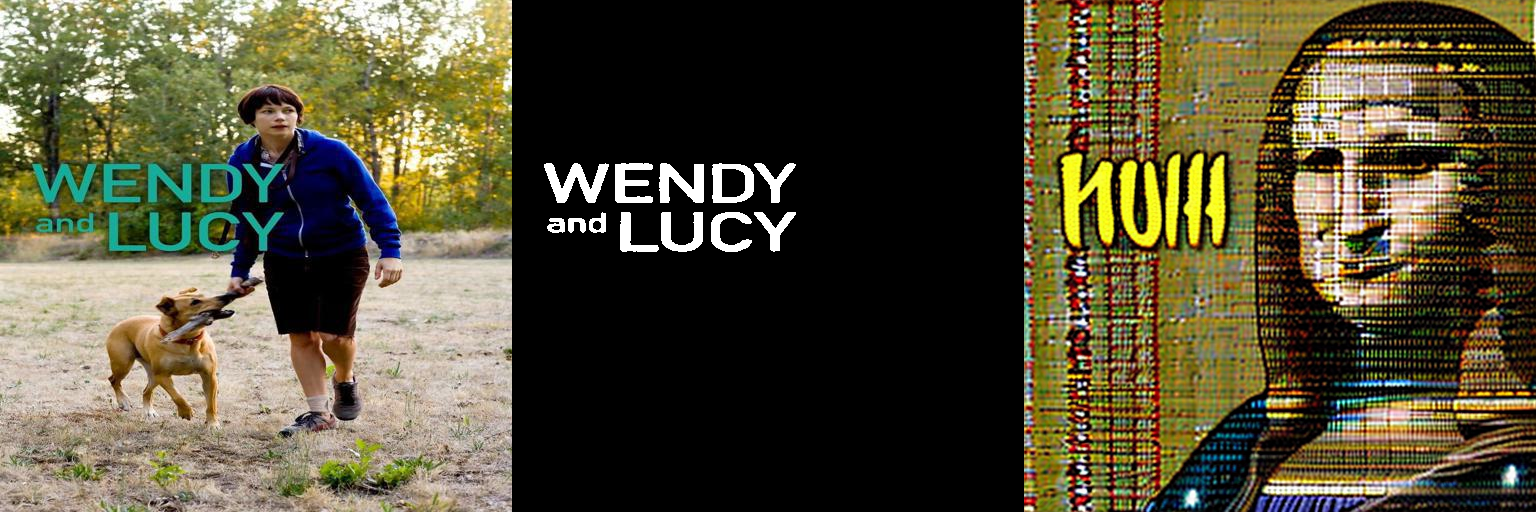

In [9]:
from diffusers import ControlNetModel, EulerAncestralDiscreteScheduler, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import make_image_grid


controlnet = ControlNetModel.from_pretrained(
        "GoGiants1/GlyphControls", 
        torch_dtype=torch.float16, 
        use_safetensors=True,
        variant="fp16", 
        revision="laion10M_epoch_6",
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True, variant="fp16",
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

control_image = binary_mask_to_pil(mask_w_patchify).convert("RGB")
output = pipe(
    "the mona lisa", image=control_image, 
).images[0]

img = make_image_grid([input_image, control_image, output], rows=1, cols=3)

display(img)